# Práctica No. 3: Cola M/M/1

*Autor: Jhon Jairo Padilla Aguilar, PhD.*

## Objetivos:

Ahora veamos como simular un puerto de un switch con llegadas exponenciales entre paquetes y tamaños de paquetes exponencialmente distribuidos.  Además, con una disciplina de cola tipo FIFO y sin límite de tamaño de los paquetes o la cola.  Este sistema se conoce como M/M/1 y tiene unas expresiones analíticas para el tamaño medio de la cola y los tiempos medios de espera.

## Topología de la red:

La topología es igual a la de la práctica anterior y se puede observar en la figura siguiente:
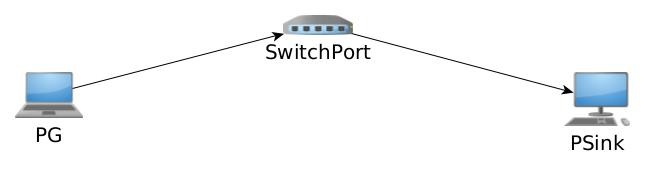

# Descripción del Código:

Inicialmente se cargan las librerías necesarias para la simulación.  En este caso se incluyen las librerías random (generación de numeros aleatorios), functools (facilita definición de funciones que retornan una muestra de una función), simpy (Simulación de eventos discretos), matplotlib (gráficos) y SimComponents (se importan los elementos de red: PacketGenerator, PacketSink, SwitchPort, PortMonitor).  El código es el siguiente:

In [1]:
import random
import functools
import simpy
import matplotlib.pyplot as plt
from SimComponents import PacketGenerator, PacketSink, SwitchPort, PortMonitor

A continuación se crean las variables adist, sdist y samp_dist, las cuales toman valores distribuidos exponencialmente, adist (tiempo entre llegadas) tiene una media de 0.5, sdist (tamaño de los paquetes) tiene una media de 0.01 y samp_dist tiene una media de 1.  También se crea la variable port_rate, que indica el valor de la tasa de salida de los datos del puerto del switch.

In [2]:
adist = functools.partial(random.expovariate, 0.5)  # tiempo medio entre paquetes
sdist = functools.partial(random.expovariate, 0.01)  # tamaño medio de los paquetes size 100 bytes
samp_dist = functools.partial(random.expovariate, 1.0)
port_rate = 1000.0  # velocidad de transmisión en el enlace de salida

Luego, se crea el ambiente de simulación con Simpy mediante la siguiente línea de código:

In [3]:
env = simpy.Environment()  # Crear el ambiente de simulación de Simpy

Ahora se crean los componentes de la red.  El receptor de paquetes es ps, en el cual se ha deshabilitado la opción debug para que no sea tan lenta la simulación.  Se crea también el generador de paquetes, al cual se le da el nombre de Greg y se le dan los parámetros adist como tiempo entre llegadas de paquetes y sdist que es el tamaño de los paquetes.  De otro lado, el switch_port se crea con una tasa de salida dada por port_rate y un tamaño de cola de 10000 para que sea muy grande y no se llene tan fácilmente.  Finalmente, se crea un componente pm de tipo PortMonitor para seguirle la pista a la longitud de la cola a lo largo del tiempo.

In [4]:
# Crear los diferentes elementos que componen la red
ps = PacketSink(env, debug=False, rec_arrivals=True)
pg = PacketGenerator(env, "Greg", adist, sdist)
switch_port = SwitchPort(env, port_rate, qlimit=10000)
# Usar un PortMonitor para hacer seguimiento al tamaño de la cola durante la simulación
pm = PortMonitor(env, switch_port, samp_dist)

A continuación se realizan las conexiones de los diferentes componentes de la red.  La salida del generador de paquetes (pg.out) se conecta con el switch_port y la salida del switch_port se conecta con el receptor de paquetes.  Finalmente se ejecuta la simulación con el comando env.run(until=8000), es decir se simula por 8000 unidades de tiempo.

In [5]:
# Interconectar los diferentes elementos que componen la red
pg.out = switch_port
switch_port.out = ps
# Correr la simulación
env.run(until=8000)

Finalmente, se imprimen los resultados de la simulación.  Se imprimen los tiempos de espera de los paquetes, los tamaños de las colas, los tiempos entre llegadas de paquetes en el receptor, el tiempo medio de espera, los paquetes recibidos, los paquetes eliminados, los paquetes enviados, los paquetes perdidos, y finalmente la ocupación media del sistema.

In [6]:
print("Last 10 waits: "  + ", ".join(["{:.3f}".format(x) for x in ps.waits[-10:]]))
print("Last 10 queue sizes: {}".format(pm.sizes[-10:]))
print("Last 10 sink arrival times: " + ", ".join(["{:.3f}".format(x) for x in ps.arrivals[-10:]]))
print("average wait = {:.3f}".format(sum(ps.waits)/len(ps.waits)))
print("received: {}, dropped {}, sent {}".format(switch_port.packets_rec, switch_port.packets_drop, pg.packets_sent))
print("loss rate: {}".format(float(switch_port.packets_drop)/switch_port.packets_rec))
print("average system occupancy: {:.3f}".format(float(sum(pm.sizes))/len(pm.sizes)))

Last 10 waits: 0.636, 2.006, 2.619, 3.126, 1.703, 0.407, 0.202, 4.107, 3.228, 7.846
Last 10 queue sizes: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Last 10 sink arrival times: 1.733, 10.578, 0.833, 0.581, 0.052, 2.470, 1.598, 6.409, 0.421, 5.160
average wait = 1.299
received: 4042, dropped 0, sent 4042
loss rate: 0.0
average system occupancy: 0.671


Los tiempos entre llegadas dan una tasa de λ = 0.5 paquetes por segundo, y la tasa de servicio será  μ = 1.25 paquetes por segundo, lo cual da una utilización  ρ = 0.4.  El tamaño medio de la cola teórico es de ⅔ y el tiempo medio de espera es de 4/3.

Adicionalmente, para mostrar otras estadísticas, podemos usar las mediciones del receptor de paquetes (packet sink) para crear histogramas como el que se muestra en la figura de abajo.  Note la gran similitud de la gráfica con una distribución exponencial.  Esto es una demostración del teorema de Burke, el cual es útil en el análisis de redes de colas.

El código es el siguiente:

/home/jhon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


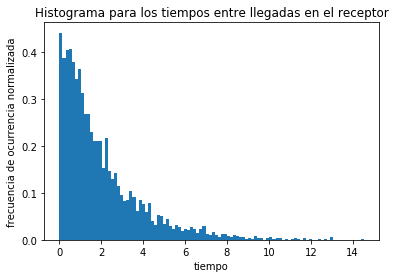

In [7]:
fig, axis = plt.subplots()
axis.hist(ps.arrivals, bins=100, normed=True)
axis.set_title("Histograma para los tiempos entre llegadas en el receptor")
axis.set_xlabel("tiempo")
axis.set_ylabel("frecuencia de ocurrencia normalizada")
# fig.savefig("ArrivalHistogram.png")
plt.show()

## Tarea:

1. Cambie el tiempo medio entre llegadas a 0.7 y corra nuevamente la simulación. Calcule nuevamente el tráfico servido (utilización del sistema) y los nuevos valores de tamaño medio de cola, tiempo medio de espera.
2. Ahora cambie el tiempo medio entre llegadas a 0.3 y corra nuevamente la simulación.  Calcule nuevamente el tráfico servido (utilización del sistema) y los nuevos valores de tamaño medio de cola, tiempo medio de espera. 
3. Compare los resultados obtenidos con los valores de tiempos medios entre llegadas de 0.3, 0.5 y 0.7.  Compare también los valores teóricos con los valores obtenidos en la simulación. Redacte conclusiones sobre todas estas comparaciones. 